# Figure 2

## Jonah Shaw, 09/27/2021

Looks at temperature, sea ice, ASR, and OLR trends in the CESM1-LE. (i.e. reproduce figures 1a-c)

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    stats, plot_trends, MidpointNormalize
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
cesmle_path = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/'

In [118]:
model_variables = ['LANDFRAC','ICEFRAC','FLUT','SOLIN','FSNT']

## Define function for computing trends

#### New slower function that uses scipy.stats.linregress via apply_ufunc and gets info on statistical significance

In [146]:
def linregress1d_np(data, times):
#     print(f"data: {data.shape} | x: {times.shape}") # different formatting syntax
    return stats.linregress(times, data)

In [147]:
def vectorized_linregress(data):
    '''
    Package for my vectorized linregress call. Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
    linregress1d_np,  # first the function
    data,  # now arguments in the order expected by 'regress1_np'
    data.year,
    input_core_dims=[["year"], ["year"],],
    output_core_dims= [[] for _ in range(5)],
    exclude_dims=set(("year",)),
    vectorize=True,
    dask="parallelized",
    output_dtypes=[data.dtype for _ in range(5)], # one per output
    )
    
    return regressed_month

In [148]:
def compute_trends_n_signif(subset_data):
    '''
    Package the trend calculating lines to save space.
    '''
    # create empty arrays for needed output
    _trends = xr.zeros_like(subset_data.groupby('time.month').mean('time'))
    _rvalues = _trends.copy()
    _pvalues = _trends.copy()

    # Potentially I should be able to format this to avoid this for loop too
    for i,_month in subset_data.groupby('time.month'):

        _yearlydata = _month.groupby('time.year').mean('time')    
        regressed_month = vectorized_linregress(_yearlydata)

        ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
        _trends[ii] = regressed_month[0]
        _rvalues[ii] = regressed_month[2]
        _pvalues[ii] = regressed_month[3]

    # Calculate statistical significance
    N = len(_yearlydata.year)
    dof=N-2

    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_rvalues*np.sqrt(N-2)/np.sqrt((1-_rvalues*_rvalues))

    _statsig=(1-_pvalues)*100
    _notnull = t > tcrit # disproving the null hypothesis (slope is zero)    
    
    return _trends,_statsig,_notnull

#### Create strings to identify ensemble members

In [119]:
def zero_strings(numz):
    
    out = ''
    for i in range(numz):
        out+='0'
    return out

ensemble_nums = []

for i in range(40): # 35ish members seem to have the right dates
    ii = str(i + 2) # things seem to start at 2 in the directory
    
    # this could be a single line
    ensemble_nums.append(zero_strings(3-len(ii))+ii)

#### Find and collect paths for each variable and ensemble

In [120]:
path_dict = {} # first key is the ensemble number, second is the model variable

for _ensn in ensemble_nums:
    for _var in model_variables:
        _t1_file = glob.glob('%s/%s/b.e11.B20TRC5CNBDRD.f09_g16.%s.cam.h0.%s.192001-200512.nc' % (cesmle_path,_var,_ensn,_var))
        _t2_file = glob.glob('%s/%s/b.e11.BRCP85C5CNBDRD.f09_g16.%s.cam.h0.%s.200601-208012.nc' % (cesmle_path,_var,_ensn,_var))

        if (len(_t1_file) != 1) or (len(_t2_file) != 1):
#             print('glob returned ambiguous (or zero) file names for ensemble member %s' % _ensn)
            break
        try:
            path_dict[_ensn][_var]=[*_t1_file,*_t2_file]
#             path_dict[_ensn].append([_t1_file,_t2_file])
        except:
            path_dict[_ensn] = {_var: [*_t1_file,*_t2_file]}
#         print(_t1_file)
#         print(_t2_file)
#     break
    

#### Land fraction in constant between ensembles and in time, so we only need to store it once.

In [138]:
ex_files = path_dict['002']

_landfrac = xr.open_mfdataset(ex_files['LANDFRAC'])['LANDFRAC'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(59,None)).isel(time=0)

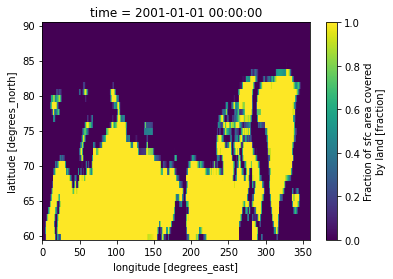

In [139]:
_landfrac.plot()

#### Compute trends in zonally-averaged OLR

In [144]:
_olr = xr.open_mfdataset(ex_files['FLUT'])['FLUT'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(59,None))

In [150]:
_olr

<xarray.DataArray 'FLUT' (time: 240, lat: 33, lon: 288)>
dask.array<getitem, shape=(240, 33, 288), dtype=float32, chunksize=(179, 33, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 59.84 60.79 61.73 62.67 ... 87.17 88.12 89.06 90.0
  * time     (time) object 2001-01-01 00:00:00 ... 2020-12-01 00:00:00
Attributes:
    Sampling_Sequence:  rad_lwsw
    units:              W/m2
    long_name:          Upwelling longwave flux at top of model
    cell_methods:       time: mean

In [149]:
compute_trends_n_signif(_olr)

NotImplementedError: multiple outputs from apply_ufunc not yet supported with dask='parallelized'

In [127]:
_subset = _landfrac.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(59,None))

In [129]:
_subset['LANDFRAC']

<xarray.DataArray 'LANDFRAC' (time: 240, lat: 33, lon: 288)>
dask.array<getitem, shape=(240, 33, 288), dtype=float32, chunksize=(179, 33, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 59.84 60.79 61.73 62.67 ... 87.17 88.12 89.06 90.0
  * time     (time) object 2001-01-01 00:00:00 ... 2020-12-01 00:00:00
Attributes:
    units:         fraction
    long_name:     Fraction of sfc area covered by land
    cell_methods:  time: mean

In [43]:
mayfiles = glob.glob('%s/%s/b.e11.B20TRC5CNBDRD.f09_g16.???.cam.h0.%s.192001-200512.nc' % (cesmle_path,model_variables[1],model_variables[1]))

In [44]:
mayfiles.sort()
mayfiles

['/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//LANDFRAC/b.e11.B20TRC5CNBDRD.f09_g16.002.cam.h0.LANDFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//LANDFRAC/b.e11.B20TRC5CNBDRD.f09_g16.003.cam.h0.LANDFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//LANDFRAC/b.e11.B20TRC5CNBDRD.f09_g16.004.cam.h0.LANDFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//LANDFRAC/b.e11.B20TRC5CNBDRD.f09_g16.005.cam.h0.LANDFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//LANDFRAC/b.e11.B20TRC5CNBDRD.f09_g16.006.cam.h0.LANDFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//LANDFRAC/b.e11.B20TRC5CNBDRD.f09_g16.007.cam.h0.LANDFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections

In [42]:
mayfiles.sort()
mayfiles

['/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//ICEFRAC/b.e11.B20TRC5CNBDRD.f09_g16.002.cam.h0.ICEFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//ICEFRAC/b.e11.B20TRC5CNBDRD.f09_g16.003.cam.h0.ICEFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//ICEFRAC/b.e11.B20TRC5CNBDRD.f09_g16.004.cam.h0.ICEFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//ICEFRAC/b.e11.B20TRC5CNBDRD.f09_g16.005.cam.h0.ICEFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//ICEFRAC/b.e11.B20TRC5CNBDRD.f09_g16.006.cam.h0.ICEFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//ICEFRAC/b.e11.B20TRC5CNBDRD.f09_g16.007.cam.h0.ICEFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM

In [35]:
all_ens

['b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h0.ICEFRAC.208101-210012.nc',
 'b.e11.B20TRC5CNBDRD.f09_g16.OIC.002.cam.h0.ICEFRAC.192001-199912.nc',
 'b.e11.BRCP85C5CNBDRD.f09_g16.033.cam.h0.ICEFRAC.200601-208012.nc',
 'b.e11.B20TRLENS_RCP85.f09_g16.xbmb.009.cam.h0.ICEFRAC.192001-202912.nc',
 'b.e11.BRCP85C5CNBDRD.f09_g16.027.cam.h0.ICEFRAC.208101-210012.nc',
 'b.e11.BRCP85C5CNBDRD.f09_g16.034.cam.h0.ICEFRAC.200601-210012.nc',
 'b.e11.B20TRLENS_RCP85.f09_g16.xghg.008.cam.h0.ICEFRAC.200601-208012.nc',
 'b.e11.B1850C5CN.f09_g16.005.cam.h0.ICEFRAC.200001-209912.nc',
 'b.e11.B20TRC5CNBDRD.f09_g16.035.cam.h0.ICEFRAC.192001-200512.nc',
 'f.e11.F1850C5CN.f09_f09.001.cam.h0.ICEFRAC.200001-209912.nc',
 'b.e11.BRCP85C5CNBDRD.f09_g16.014.cam.h0.ICEFRAC.208101-210012.nc',
 'b.e11.BRCP85C5CNBDRD.f09_g16.006.cam.h0.ICEFRAC.208101-210012.nc',
 'b.e11.B20TRLENS_RCP85.f09_g16.xghg.016.cam.h0.ICEFRAC.200601-208012.nc',
 'b.e11.B20TRC5CNBDRD.f09_g16.020.cam.h0.ICEFRAC.192001-200512.nc',
 'b.e11.B20TRLENS_RCP85.f

In [29]:
ls $cesmle_path

ABSORB/          dst_c3DDF/         num_a2DDF/    so4_a3_SRF/
ANRAIN/          dst_c3SFWET/       num_a2_logm/  so4_c1/
ANSNOW/          DTCOND/            num_a2_logv/  so4_c1DDF/
AODABS/          DTV/               num_a2SFWET/  so4_c1SFWET/
AODDUST1/        EXTINCT/           num_a3DDF/    so4_c2/
AODDUST2/        FICE/              num_a3_logm/  so4_c2DDF/
AODDUST3/        FISCCP1_COSP/      num_a3_logv/  so4_c2SFWET/
AODVIS/          FLDS/              num_a3SFWET/  so4_c3/
AQRAIN/          FLNS/              num_c1/       so4_c3DDF/
AQSNOW/          FLNSC/             num_c1DDF/    so4_c3SFWET/
AREI/            FLNT/              num_c1SFWET/  soa_a1DDF/
AREL/            FLNTC/             num_c2/       soa_a1_logm/
AWNC/            FLUT/              num_c2DDF/    soa_a1_logv/
AWNI/            FLUTC/             num_c2SFWET/  soa_a1SFWET/
bc_a1DDF/        FREQI/             num_c3/       soa_a1_SRF/
bc_a1_logm/      FREQL/             num_c3DDF/    soa_a2DDF/
bc_a1_logv/      FR

In [10]:
ls $cesmle_path/LENS-CMIP5-O3/atm/proc/tseries/monthly/LANDFRAC

b.e11.BRCP85C5CNBDRD.f09_g16.034_CMIP5-O3.cam.h0.LANDFRAC.200601-210012.nc
b.e11.BRCP85C5CNBDRD.f09_g16.035_CMIP5-O3.cam.h0.LANDFRAC.200601-210012.nc


In [15]:
ls $cesmle_path/LENS-CMIP5-O3/atm/proc/tseries/monthly/CLDTOT

b.e11.BRCP85C5CNBDRD.f09_g16.034_CMIP5-O3.cam.h0.CLDTOT.200601-210012.nc
b.e11.BRCP85C5CNBDRD.f09_g16.035_CMIP5-O3.cam.h0.CLDTOT.200601-210012.nc


In [12]:
ls $cesmle_path/CESM-CAM5-AMIP-SF

f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_1920sst.001/
f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_AERBMBsst.001/
f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_AERBMBsst.002/
f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_AERBMBsst.003/
f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_AERBMBsst.004/
f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_AERBMBsst.005/
f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_AERBMBsst.006/
f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_AERBMBsst.007/
f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_AERBMBsst.008/
f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_AERBMBsst.009/
f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_AERBMBsst.010/
f.e11.FAMIPC5CN_RCP85.f09_f09.AERBMBemis_1920sst.001/
f.e11.FAMIPC5CN_RCP85.f09_f09.AERBMBemis_1920sst.002/
f.e11.FAMIPC5CN_RCP85.f09_f09.AERBMBemis_1920sst.003/
f.e11.FAMIPC5CN_RCP85.f09_f09.AERBMBemis_1920sst.004/
f.e11.FAMIPC5CN_RCP85.f09_f09.AERBMBemis_1920sst.005/
f.e11.FAMIPC5CN_RCP85.f09_f09.AERBMBemis_1920sst.006/
f.e11.FAMIPC5CN_RCP85.f09_f09.AERBMBemis_1920sst.007/
f.e11.FAMIPC5CN_RCP85.f09_f09.

In [20]:
ls $cesmle_path/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/CLDTOT

b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.040001-049912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.050001-059912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.060001-069912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.070001-079912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.080001-089912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.090001-099912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.100001-109912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.110001-119912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.120001-129912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.130001-139912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.140001-149912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.150001-159912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.160001-169912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.170001-179912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.180001-189912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.190001-199912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.200001-209912.